In [1]:
import geopandas as gpd
from folium import Choropleth, Circle, Marker
from folium.plugins import MarkerCluster, HeatMap
import folium
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

We define a function `embed_map()` for displaying interactive maps. It accepts two arguments: the variable containing the map, and the name of the HTML file where the map will be saved.

This function ensures that the maps are visible [in all web browsers](https://github.com/python-visualization/folium/issues/812).

In [2]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

# Map of boston 

In [3]:
m1 = folium.Map(location=[42.32,-71.0589], tiles ='openstreetmap', zoom_start=10)
m1

Now, we'll add some crime data to the map!

We won't focus on the data loading step. Instead, you can imagine you are at a point where you already have the data in a pandas DataFrame crimes. The first five rows of the data are shown below.

In [4]:
crimes = pd.read_csv('Boston_crimes.csv', encoding ='latin1')
crimes.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


NOTE: Loading the Boston file without `encoding='latin1'` raises a `UnicodeDecoderError`: 'utf-8 codec can't decode byte 0xa0 in position 24: Invalid start byte. 

solving this requires setting encoding ='latin1'

## Plotting points

To reduce the amount of data we need to fit on the map, we'll (temporarily) confine our attention to daytime robberies.

In [5]:
dayrob = crimes[((crimes['OFFENSE_CODE_GROUP']=='Robbery') & (crimes['HOUR'].isin(range(6, 19))))]
dayrob.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
42,I182070888,301,Robbery,ROBBERY - STREET,A1,76,NaN,2018-09-03 15:45:00,2018,9,Monday,15,Part One,NaN,NaN,NaN,"(0.00000000, 0.00000000)"
62,I182070865,301,Robbery,ROBBERY - STREET,NaN,,NaN,2018-09-03 15:54:00,2018,9,Monday,15,Part One,NaN,42.315809,-71.098290,"(42.31580852, -71.09829029)"
273,I182070621,361,Robbery,ROBBERY - OTHER,A7,23,NaN,2018-09-02 18:09:00,2018,9,Sunday,18,Part One,MARION ST,42.377256,-71.036674,"(42.37725644, -71.03667354)"
299,I182070598,311,Robbery,ROBBERY - COMMERCIAL,A15,60,NaN,2018-09-02 17:15:00,2018,9,Sunday,17,Part One,RUTHERFORD AVE,42.371673,-71.063264,"(42.37167264, -71.06326413)"
345,I182070549,301,Robbery,ROBBERY - STREET,B2,282,NaN,2018-09-02 07:00:00,2018,9,Sunday,7,Part One,WARREN ST,42.328234,-71.083290,"(42.32823419, -71.08328981)"


Now we want to add markers to the map with folium.Marker(). Each marker below corresponds to a different robbery.

We've already imported Marker() from folium we will just go ahead and use it

In [6]:
m2 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=12)

#Add points were crimes were committed to map
for idx, row in dayrob.iterrows():
    if not math.isnan(row['Long']) and not math.isnan(row['Lat']):
        Marker([row['Lat'], row['Long']]).add_to(m2)
m2
    

NOTE: Location values can't contain NaN (Not a Number). So we use math.isnan to make sure only rows with real values are used.

folium.plugins.MarkerCluster

If we have a lot of markers to add, folium.plugins.MarkerCluster() can help to declutter the map. Each marker is added to a MarkerCluster object. Decluttering means that the closest points will be grouped under one main cluster.The individual points will be seen if we zoom in to that particular 'ball'. This ensures that our map doesn't look too stuffy.

In [7]:
m3 = folium.Map(location=[42.32,-71.0589], tiles ='cartodbpositron', zoom_start=12)

#Add MarkerCluster 
mc=MarkerCluster()
for idx, row in dayrob.iterrows():
    if not math.isnan(row['Long']) and not math.isnan(row['Lat']):
        mc.add_child(Marker([row['Lat'], row['Long']]))
m3.add_child(mc)
m3

## Bubble maps
A bubble map uses circles instead of markers. By varying the size and color of each circle, we can also show the relationship between location and two other variables.

We create a bubble map by using folium.Circle() to iteratively add circles. In the code cell below, robberies that occurred in hours 9-12 are plotted in green, whereas robberies from hours 13-17 are plotted in red.

In [8]:
#I dropped all Latitude and Longitude coordinates that were NaN. Map will not be generated when there are NaNs in Lat and Long
dayrob.dropna(subset=['Lat','Long'], inplace=True)
dayrob.head()

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
62,I182070865,301,Robbery,ROBBERY - STREET,NaN,,NaN,2018-09-03 15:54:00,2018,9,Monday,15,Part One,NaN,42.315809,-71.098290,"(42.31580852, -71.09829029)"
273,I182070621,361,Robbery,ROBBERY - OTHER,A7,23,NaN,2018-09-02 18:09:00,2018,9,Sunday,18,Part One,MARION ST,42.377256,-71.036674,"(42.37725644, -71.03667354)"
299,I182070598,311,Robbery,ROBBERY - COMMERCIAL,A15,60,NaN,2018-09-02 17:15:00,2018,9,Sunday,17,Part One,RUTHERFORD AVE,42.371673,-71.063264,"(42.37167264, -71.06326413)"
345,I182070549,301,Robbery,ROBBERY - STREET,B2,282,NaN,2018-09-02 07:00:00,2018,9,Sunday,7,Part One,WARREN ST,42.328234,-71.083290,"(42.32823419, -71.08328981)"
527,I182070342,381,Robbery,ROBBERY - CAR JACKING,E18,490,NaN,2018-09-01 17:05:00,2018,9,Saturday,17,Part One,CUMMINS HWY,42.276453,-71.112980,"(42.27645319, -71.11297971)"


In [9]:
# Create a base map
m4 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=13)

def color_producer(val):
    if val <= 12:
        return 'forestgreen'
    else:
        return 'darkred'

#Def function to vary radii of circles
def radius_producer(val):
    if val <= 12:
        return '5'
    else:
        return '30'

# Add a bubble map to the base map
for i in range(0,len(dayrob)):
    Circle(
        location=[dayrob.iloc[i]['Lat'], dayrob.iloc[i]['Long']],
        radius=radius_producer(dayrob.iloc[i]['HOUR']),
        color=color_producer(dayrob.iloc[i]['HOUR'])).add_to(m4)

# Display the map
m4

Note that folium.Circle() takes several arguments:

`location` is a list containing the center of the circle, in latitude and longitude.

`radius` sets the radius of the circle.
- Note that in a traditional bubble map, the radius of each circle is allowed to vary. We can implement this by defining a function similar to the `color_producer()` function that is used to vary the color of each circle.
color sets the color of each circle.

The `color_producer()` function is used to visualize the effect of the hour on robbery location.

## Heat Map

To create a heatmap, we use `folium.plugins.HeatMap()`. This shows the density of crime in different areas of the city, where red areas have relatively more criminal incidents.

As we'd expect for a big city, most of the crime happens near the center.

In [10]:
m5 = folium.Map(location =[42.32, -71.0589], tiles='cartodbpositron', zoom_start=12)

HeatMap(data=dayrob[['Lat','Long']], radius=12).add_to(m5)
m5

## Choropleth Maps

To understand how crime varies by police district, we'll create a choropleth map.

As a first step, we create a GeoDataFrame where each district is assigned a different row, and the "geometry" column contains the geographical boundaries.

In [11]:
police = pd.read_csv('Police_Districts.csv')
police.head()

,OBJECTID,DISTRICT,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTArea,ShapeSTLength
0,1,A15,A15,A,15,15,3.798392e+07,57616.007190
1,2,A7,A7,A,7,7,1.401151e+08,138468.216080
2,3,A1,A1,A,1,1,4.448484e+07,48957.671219
3,4,C6,C6,C,6,6,1.236919e+08,93389.518748
4,5,D4,D4,D,4,4,6.999546e+07,41016.808977


It wasn't too helpful so I will load a shapefile. That will get me a geometry column

In [12]:
district = gpd.read_file('Police_Districts.shp')
district.head()

,OBJECTID,DISTRICT,ID,BPDGIS_GIS,DISTRICT_,DISTRICT__,ShapeSTAre,ShapeSTLen,geometry
0,1,A15,A15,A,15,15,3.798392e+07,57616.007190,"MULTIPOLYGON (((771204.900 2967614.950, 771205..."
1,2,A7,A7,A,7,07,1.401151e+08,138468.216080,"MULTIPOLYGON (((792187.300 2969573.400, 792187..."
2,3,A1,A1,A,1,01,4.448484e+07,48957.671219,"POLYGON ((777233.200 2959748.000, 777315.300 2..."
3,4,C6,C6,C,6,06,1.236919e+08,93389.518748,"POLYGON ((779407.000 2954363.800, 779390.500 2..."
4,5,D4,D4,D,4,04,6.999546e+07,41016.808977,"POLYGON ((771263.359 2955490.741, 771418.507 2..."


Lets's get the boundaries of all the police districts in Boston

In [13]:
police_district = district[['DISTRICT','geometry']].set_index('DISTRICT')
police_district.head()

,geometry
DISTRICT,
A15,"MULTIPOLYGON (((771204.900 2967614.950, 771205..."
A7,"MULTIPOLYGON (((792187.300 2969573.400, 792187..."
A1,"POLYGON ((777233.200 2959748.000, 777315.300 2..."
C6,"POLYGON ((779407.000 2954363.800, 779390.500 2..."
D4,"POLYGON ((771263.359 2955490.741, 771418.507 2..."


Now let's go to the main crimes dataframe and find out how many crimes were committed in each district

In [14]:
dist_crime = crimes.DISTRICT.value_counts()
dist_crime

B2     49945
C11    42530
D4     41915
A1     35717
B3     35442
C6     23460
D14    20127
E13    17536
E18    17348
A7     13544
E5     13239
A15     6505
Name: DISTRICT, dtype: int64

It's very important that `dist_crime` has the same index as `police_district` - this is how the code knows how to match the geographical boundaries with appropriate colors.

Using the folium.Choropleth() class, we can create a choropleth map

In [15]:
m6=folium.Map(location=[42.32, -71.0589], tiles='openstreetmap', zoom_start=12)

Choropleth(geo_data=police_district.__geo_interface__,
           data=dist_crime,
           key_on='feature.id',
           fill_color='YlGnBu',
           legend_name='Major criminal incidence in Boston from 2018-2020'
           ).add_to(m6)
embed_map(m6, 'm6.html')

Note that `folium.Choropleth()` takes several arguments:

- `geo_data` is a `GeoJSON FeatureCollection` containing the boundaries of each geographical area.

In the code above, we convert the districts GeoDataFrame to a GeoJSON FeatureCollection with the `__geo_interface__` attribute.

- `data` is a Pandas Series containing the values that will be used to color-code each geographical area.

- `key_on` will always be set to `feature.id`

This refers to the fact that the `GeoDataFrame` used for `geo_data` and the Pandas Series provided in data have the same index.

To understand the details, we'd have to look more closely at the structure of a `GeoJSON` Feature Collection (where the value corresponding to the "features" key is a list, wherein each entry is a dictionary containing an "id" key).

- `fill_color` sets the color scale.

- `legend_name` labels the legend in the top right corner of the map.

# EXERCISE

## Introduction

You are an urban safety planner in Japan, and you are analyzing which areas of Japan need extra earthquake reinforcement.  Which areas are both high in population density and prone to earthquakes?

<center>
<img src="https://i.imgur.com/Kuh9gPj.png" width="450"><br/>
</center>

Before you get started, Make sure you have imported all libraries and dependencies

###  Do earthquakes coincide with plate boundaries

Create a DataFrame `plate_boundaries` that shows global plate boundaries.  The "coordinates" column is a list of (latitude, longitude) locations along the boundaries.

In [104]:
plate_boundaries = gpd.read_file('trench.shp')
plate_boundaries['coordinates'] = plate_boundaries.apply(lambda x: [(b,a) for (a,b) in list(x.geometry.coords)], axis='columns')
plate_boundaries.drop('geometry', axis=1, inplace=True)

plate_boundaries.head(5)

,Id,strnum,platecode,datatype,dtnum,refnum,appearance,disappeara,color,geogdesc,coordinates
0,None,412,101,TR,1,9921,30.0,-999.0,1,GULF OF ALASKA TRENCH,"[(51.5103, -130.6539), (51.6287, -130.7708), (..."
1,None,413,101,TR,1,9829,10.0,-999.0,1,TRENCH BET JUAN DE FUCA & N. AMERICA,"[(40.2584, -124.4415), (40.317, -124.4718), (4..."
2,None,414,215,TR,1,9788,6.2,-999.0,4,"MIDDLE AMERICA TRENCH, MEXICO","[(21.2508, -106.4797), (21.1354, -106.4726), (..."
3,None,415,215,TR,1,9788,12.5,-999.0,4,"MIDDLE AMERICA TRENCH, MEXICO","[(18.1881, -104.528), (18.1349, -104.4743), (1..."
4,None,416,201,TH,1,2019,0.0,-999.0,7,"THRUST FAULT, SW AND S OF GULF OF PARIA, VENEZUE","[(10.0827, -64.6176), (10.0651, -64.5539), (10..."


# Health Facilities in Ghana

Importing dataset of all health facilities in Ghana.

In [16]:
health = pd.read_csv('Ghana_health_facilities.csv')
health.head()

,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098


We have to convert the DataFrame into a GeoDataFrame in order to get the Geometry column

In [23]:
ghana_health = gpd.GeoDataFrame(
    health, crs="EPSG:32630",
    geometry=gpd.points_from_xy(health.Longitude, health.Latitude))

ghana_health.head()

,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude,geometry
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317,POINT (-1.96317 7.40801)
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592,POINT (-1.58592 6.46312)
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982,POINT (-1.34982 6.22393)
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)


We are importing yet another dataset containing the boundary coordinates of the regions of Ghana.

In [18]:
regions=gpd.read_file('Regions_in_Ghana.shp')
regions.head()

,Region,geometry
0,Ashanti,"POLYGON ((686446.075 842986.894, 686666.193 84..."
1,Brong Ahafo,"POLYGON ((549970.457 968447.094, 550073.003 96..."
2,Central,"POLYGON ((603176.584 695877.238, 603248.424 69..."
3,Eastern,"POLYGON ((807307.254 797910.553, 807311.908 79..."
4,Greater Accra,"POLYGON ((858081.638 676424.913, 858113.115 67..."


In [19]:
regions.crs

{'init': 'epsg:32630'}

In [27]:
ghana_health.crs = {'init':'epsg:32630'}
ghana_health.head()

,Region,District,FacilityName,Type,Town,Ownership,Latitude,Longitude,geometry
0,Ashanti,Offinso North,A.M.E Zion Clinic,Clinic,Afrancho,CHAG,7.40801,-1.96317,POINT (-1.96317 7.40801)
1,Ashanti,Bekwai Municipal,Abenkyiman Clinic,Clinic,Anwiankwanta,Private,6.46312,-1.58592,POINT (-1.58592 6.46312)
2,Ashanti,Adansi North,Aboabo Health Centre,Health Centre,Aboabo No 2,Government,6.22393,-1.34982,POINT (-1.34982 6.22393)
3,Ashanti,Afigya-Kwabre,Aboabogya Health Centre,Health Centre,Aboabogya,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)
4,Ashanti,Kwabre,Aboaso Health Centre,Health Centre,Aboaso,Government,6.84177,-1.61098,POINT (-1.61098 6.84177)


<AxesSubplot:>

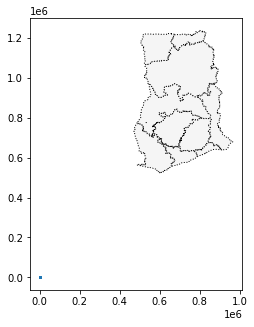

In [41]:
# Create a map
ax = regions.plot(figsize=(5,5), color='whitesmoke', linestyle=':', edgecolor='black')

ghana_health.plot(markersize=1, ax=ax)

<AxesSubplot:>

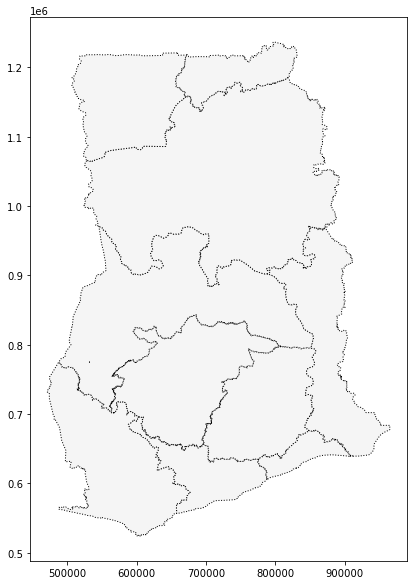

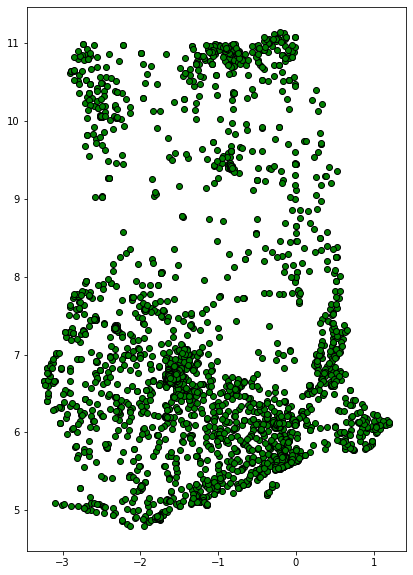

In [31]:
ax = regions.plot(figsize=(10,10), color='whitesmoke', linestyle=':', edgecolor='black')
ghana_health.plot(figsize=(10,10), color='green', edgecolor='black')